In [1]:
import pandas as pd
import sqlite3
import sqlalchemy as db
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns
import datetime

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Function to create a dataframe of MTA turnstile data spanning 7/3/2021 to 9/25/21

# Data from http://web.mta.info/developers/turnstile.html

def get_data(weeks):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    
    for week in weeks:
        week_url = url.format(week)
        dfs.append(pd.read_csv(week_url, parse_dates = [['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)

weeks = [210925, 210918, 210911, 210904, 210828, 210821, 210814, 210807, 210731, 210724, 210717, 210710, 210703]

In [5]:
# Connect to SQL database

engine = db.create_engine('sqlite:///data/mta_data.db')

# Check SQL connection
engine.table_names()

/tmp/ipykernel_296470/2209206835.py:6: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['mta_data']

In [6]:
# Read in SQL 

mta_raw = pd.read_sql('SELECT [C/A], [UNIT], [SCP], [STATION], [LINENAME], [DIVISION], [DATE], [TIME], [DESC], [ENTRIES], [EXITS] FROM mta_data;', engine)

In [7]:
mta_raw

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,00:00:00,REGULAR,7637026,2613455
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,04:00:00,REGULAR,7637036,2613457
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,08:00:00,REGULAR,7637047,2613478
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,12:00:00,REGULAR,7637104,2613524
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,16:00:00,REGULAR,7637236,2613561
...,...,...,...,...,...,...,...,...,...,...,...
2724413,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/02/2021,05:00:00,REGULAR,5554,585
2724414,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/02/2021,09:00:00,REGULAR,5554,585
2724415,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/02/2021,13:00:00,REGULAR,5554,585
2724416,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,07/02/2021,17:00:00,REGULAR,5554,585


In [8]:
# Read in data with parse_dates creating a datetime column

mta_datetime = get_data(weeks)

In [9]:
# Sort values and drop duplicates

mta_datetime.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)

mta_datetime.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [10]:
# Group rows by turnstile

turnstiles_daily = mta_datetime.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],as_index=False).ENTRIES.first() 

# Then find the daily entries at each turnstile

turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_296470/3545793918.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [11]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,2021-06-26 00:00:00,7592792,NaT,NaN
1,A002,R051,02-00-00,59 ST,2021-06-26 04:00:00,7592804,2021-06-26 00:00:00,7592792.0
2,A002,R051,02-00-00,59 ST,2021-06-26 08:00:00,7592816,2021-06-26 04:00:00,7592804.0
3,A002,R051,02-00-00,59 ST,2021-06-26 12:00:00,7592870,2021-06-26 08:00:00,7592816.0
4,A002,R051,02-00-00,59 ST,2021-06-26 16:00:00,7592992,2021-06-26 12:00:00,7592870.0


In [12]:
# Drop NaN rows

turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [13]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,2021-06-26 04:00:00,7592804,2021-06-26 00:00:00,7592792.0
2,A002,R051,02-00-00,59 ST,2021-06-26 08:00:00,7592816,2021-06-26 04:00:00,7592804.0
3,A002,R051,02-00-00,59 ST,2021-06-26 12:00:00,7592870,2021-06-26 08:00:00,7592816.0
4,A002,R051,02-00-00,59 ST,2021-06-26 16:00:00,7592992,2021-06-26 12:00:00,7592870.0
5,A002,R051,02-00-00,59 ST,2021-06-26 20:00:00,7593116,2021-06-26 16:00:00,7592992.0


In [14]:
# Function to determine the daily entries at each turnstile

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [15]:
# Compute daily entries for each turnstile

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [16]:
# Group all the turnstiles at all stations

stations_daily = turnstiles_daily.groupby(["STATION", "DATE_TIME"])[['DAILY_ENTRIES']].sum().reset_index()

In [17]:
# Find the busiest stations

busy_stations = stations_daily.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()

In [18]:
busy_stations.head(20)

,STATION,DAILY_ENTRIES
0,JUNCTION BLVD,5612589.0
1,34 ST-PENN STA,4911439.0
2,FULTON ST,3871541.0
3,86 ST,3511439.0
4,PATH NEW WTC,3379610.0
5,JOURNAL SQUARE,3137842.0
6,34 ST-HERALD SQ,3102136.0
7,GRD CNTRL-42 ST,3015564.0
8,42 ST-PORT AUTH,2799339.0
9,72 ST,2790482.0


In [19]:
busy_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATION        379 non-null    object 
 1   DAILY_ENTRIES  379 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.0+ KB


In [21]:
# Read in MTA spatial data

stations_geo = pd.read_csv('data/DOITT_SUBWAY_STATION_01_13SEPT2010.csv')

# Drop the unneeded columns

stations_geo.drop(['URL','OBJECTID'], axis=1, inplace=True)

# Format spatial dataframe for merging

stations_geo.rename(columns={'NAME':'STATION'}, inplace=True)
stations_geo['STATION'] = stations_geo['STATION'].str.upper()

In [22]:
# Merge spatial data with busy_stations

busy_stations_geo = pd.merge(busy_stations, stations_geo, on='STATION', how='left')
busy_stations_geo_inner = pd.merge(busy_stations, stations_geo, on='STATION', how='inner')

In [23]:
# Prepare busy_stations_geo for plotting with geopandas

busy_stations_geo.the_geom = busy_stations_geo.the_geom.str.strip('POINT ')
busy_stations_geo[['LONG','LAT']] = busy_stations_geo.the_geom.str.split(' ', expand=True)
busy_stations_geo.LONG = busy_stations_geo.LONG.str.strip('(')
busy_stations_geo.LONG = busy_stations_geo.LONG.astype(float)
busy_stations_geo.LAT = busy_stations_geo.LAT.str.strip(')')
busy_stations_geo.LAT = busy_stations_geo.LAT.astype(float)

In [24]:
# Create boroughs shapefile and initialize it

boroughs = gpd.read_file('borough_shapes/geo_export_d86d1c64-637c-4b79-9310-4aa2d5aeefdb.shp')
crs = {'init':'epsg:4326'}

In [25]:
# Create geometry for plot

geometry = [Point(xy) for xy in zip(busy_stations_geo['LONG'], busy_stations_geo['LAT'])]

/home/mattiboi/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

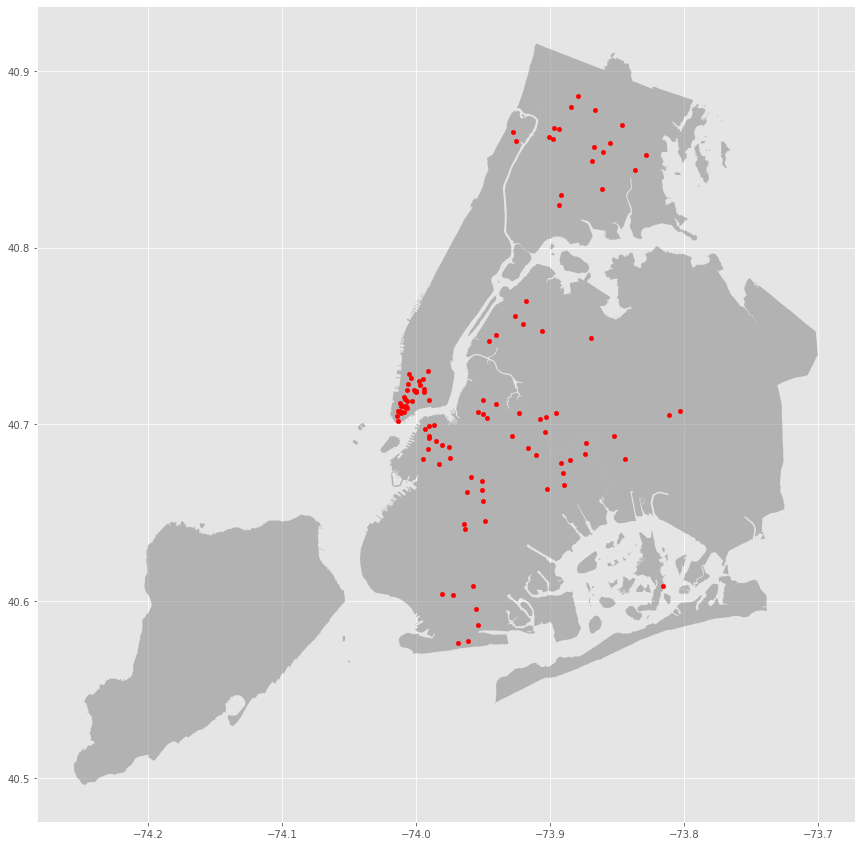

In [26]:
# Create geodataframe and map it

geo_stations= gpd.GeoDataFrame(busy_stations_geo, crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax, alpha=0.5, color='grey')
geo_stations['geometry'].plot(ax=ax, markersize=20, color='red')

#fig.savefig('station_map')

In [27]:
# Find the busiest 20 stations that can be mapped with this data

geo_stations.sort_values(by=['DAILY_ENTRIES'], inplace=True, ascending=False)

# Drop duplicates

geo_stations.drop_duplicates(subset='DAILY_ENTRIES', keep='first', inplace=True)

top_20_analysis = geo_stations[:20]

geo_stations.dropna(inplace=True)

top_20_map = geo_stations[:20]

Text(110.95222121379967, 0.5, 'Latitude')

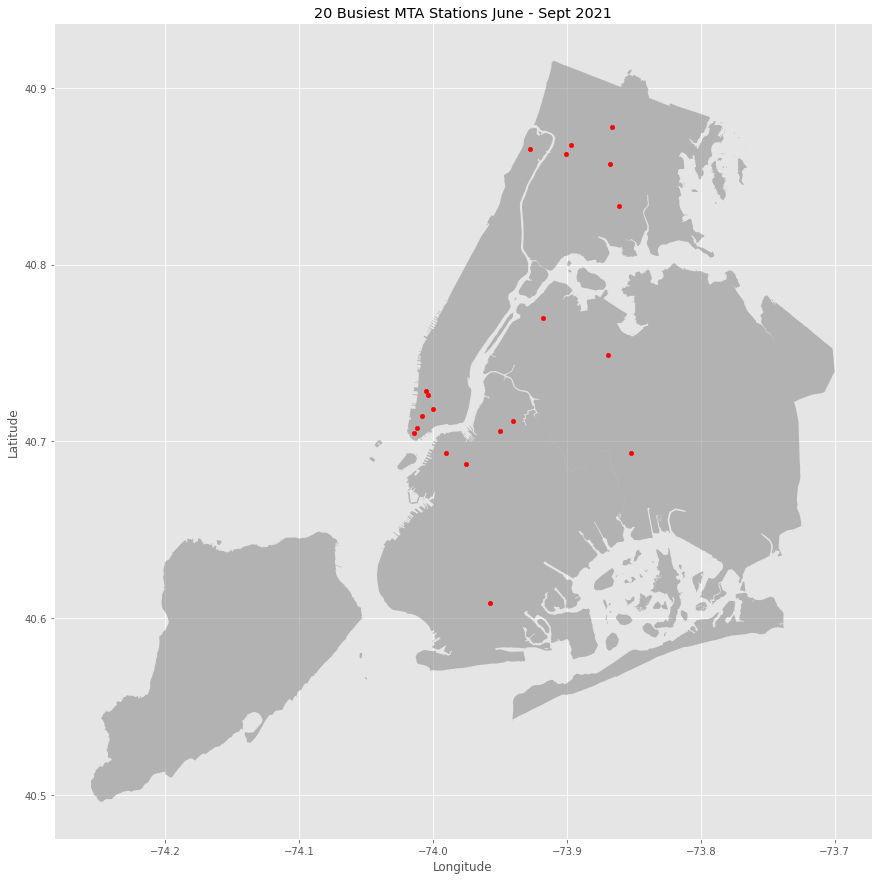

In [28]:
fig, ax = plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax, alpha=0.5, color='grey')
top_20_map['geometry'].plot(ax=ax, markersize=20, color='red')
plt.title('20 Busiest MTA Stations June - Sept 2021')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('mvp_map')

In [29]:
# Create a data mask with top_20 by station name

survey_mask = list(top_20_analysis['STATION'])

# Create a dataframe of the daily metrics for each station in top_20

stations_daily_filtered = stations_daily[stations_daily['STATION'].isin(survey_mask)]
busy_stations_filtered = busy_stations[busy_stations['STATION'].isin(survey_mask)]
busy_stations_filtered.sort_values(by='STATION', inplace=True)

/home/mattiboi/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [30]:
busy_stations_filtered.head()

# DAILY_ENTRIES should be renamed to something like 'TOTAL_ENTRIES' as this column is actually representing total entries over the observation period

,STATION,DAILY_ENTRIES
14,125 ST,2460260.0
13,14 ST-UNION SQ,2550320.0
12,23 ST,2653312.0
6,34 ST-HERALD SQ,3102136.0
1,34 ST-PENN STA,4911439.0


In [31]:
stations_daily_filtered.head()

,STATION,DATE_TIME,DAILY_ENTRIES
5537,125 ST,2021-06-26 04:00:00,318.0
5538,125 ST,2021-06-26 05:00:00,256.0
5539,125 ST,2021-06-26 08:00:00,633.0
5540,125 ST,2021-06-26 09:00:00,1386.0
5541,125 ST,2021-06-26 12:00:00,2066.0


In [32]:
busy_stations_filtered.reset_index()
busy_stations_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 14 to 15
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATION        20 non-null     object 
 1   DAILY_ENTRIES  20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 480.0+ bytes


In [33]:
# Find the average daily entrance count for each station in top_20

avg_entries = stations_daily_filtered.groupby(['STATION'])['DAILY_ENTRIES'].mean()
avg_entries = avg_entries.to_frame().reset_index()

In [34]:
# Prepare avg_entries to be merged with busy_stations_filtered

avg_entries.rename(columns={'DAILY_ENTRIES':'AVG_ENTRIES'}, inplace=True)

avg_entries.head()

,STATION,AVG_ENTRIES
0,125 ST,2234.568574
1,14 ST-UNION SQ,4628.529946
2,23 ST,2418.698268
3,34 ST-HERALD SQ,5671.180987
4,34 ST-PENN STA,4452.800544


In [35]:
# Merge busy_stations_filtered with avg_entries

busy_stations_filtered = busy_stations_filtered.merge(avg_entries)

busy_stations_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STATION        20 non-null     object 
 1   DAILY_ENTRIES  20 non-null     float64
 2   AVG_ENTRIES    20 non-null     float64
dtypes: float64(2), object(1)
memory usage: 640.0+ bytes


Text(0.5, 1.0, 'Busiest MTA Stations, July - Sept 2021')

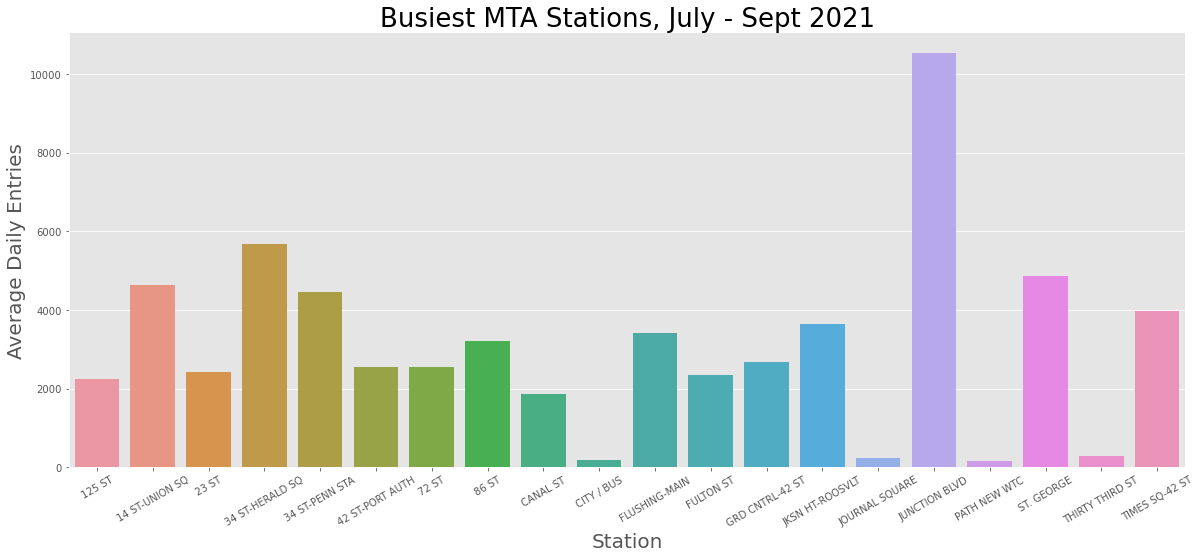

In [36]:
# Create a barplot of busy stations
fig=plt.gcf()
fig.set_size_inches(20,8)

ax = sns.barplot(x=busy_stations_filtered['STATION'], y=busy_stations_filtered['AVG_ENTRIES'])
ax.set_xlabel(xlabel='Station', fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_ylabel(ylabel='Average Daily Entries',fontsize = 20)
ax.set_title(label='Busiest MTA Stations, July - Sept 2021', fontsize=26)

#fig.savefig('busiest_stations')

In [37]:
# Prepare stations_daily_filtered for timeseries plotting

stations_daily_filtered.rename(columns={'DAILY_ENTRIES':'HOURLY_ENTRIES'}, inplace=True)

stations_daily_filtered.head()

/home/mattiboi/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,STATION,DATE_TIME,HOURLY_ENTRIES
5537,125 ST,2021-06-26 04:00:00,318.0
5538,125 ST,2021-06-26 05:00:00,256.0
5539,125 ST,2021-06-26 08:00:00,633.0
5540,125 ST,2021-06-26 09:00:00,1386.0
5541,125 ST,2021-06-26 12:00:00,2066.0


In [38]:
# Applications with datetime columns

stations_daily_filtered['DAY'] = stations_daily_filtered['DATE_TIME'].dt.day_name()
stations_daily_filtered['TIME'] = stations_daily_filtered['DATE_TIME'].dt.time
stations_daily_filtered['MONTH'] = stations_daily_filtered['DATE_TIME'].dt.month
stations_daily_filtered['WEEK'] = stations_daily_filtered['DATE_TIME'].dt.week

/tmp/ipykernel_296470/915419597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_daily_filtered['DAY'] = stations_daily_filtered['DATE_TIME'].dt.day_name()
/tmp/ipykernel_296470/915419597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_daily_filtered['TIME'] = stations_daily_filtered['DATE_TIME'].dt.time
/tmp/ipykernel_296470/915419597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [39]:
#stations_daily_filtered.head(50)

In [40]:
#stations_daily_filtered.info()

In [41]:
# Create filtered_stations_grouped for plotting 
filtered_stations_grouped = stations_daily_filtered.groupby(['STATION','DAY'])[['HOURLY_ENTRIES']].sum().reset_index()

#Prepare filtered_stations_group by renaming columns and ordering weekdays correctly

filtered_stations_grouped.rename(columns={'HOURLY_ENTRIES':'TOTAL_OBSERVED_ENTRIES'}, inplace=True)
filtered_stations_grouped['WEEKDAY_ORDERED'] = pd.Categorical(filtered_stations_grouped['DAY'], 
                                                              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)

In [42]:
filtered_stations_grouped.head(15)

,STATION,DAY,TOTAL_OBSERVED_ENTRIES,WEEKDAY_ORDERED
0,125 ST,Friday,402395.0,Friday
1,125 ST,Monday,358864.0,Monday
2,125 ST,Saturday,286828.0,Saturday
3,125 ST,Sunday,232793.0,Sunday
4,125 ST,Thursday,384214.0,Thursday
5,125 ST,Tuesday,396579.0,Tuesday
6,125 ST,Wednesday,398587.0,Wednesday
7,14 ST-UNION SQ,Friday,412807.0,Friday
8,14 ST-UNION SQ,Monday,352286.0,Monday
9,14 ST-UNION SQ,Saturday,329310.0,Saturday


In [43]:
# Binning 'TIME' of filtered_stations_grouped:

time_bins = ['00:00:00','06:00:00','12:00:00','18:00:00','23:59:59']
TRAFFIC_CATEGORY = ['Midnight to 6am','6am to Noon','Noon to 6pm','6pm to Midnight']
#filtered_stations_grouped['TIME'] = pd.to_datetime(filtered_stations_grouped['TIME'], format='%H:%M:%S').dt.time


conversion = []

for i in time_bins:
    i = datetime.datetime.strptime(i, '%H:%M:%S')
    conversion.append(i)
    
conversion

# not helpful

[datetime.datetime(1900, 1, 1, 0, 0),
 datetime.datetime(1900, 1, 1, 6, 0),
 datetime.datetime(1900, 1, 1, 12, 0),
 datetime.datetime(1900, 1, 1, 18, 0),
 datetime.datetime(1900, 1, 1, 23, 59, 59)]

In [44]:
#filtered_stations_grouped.info()

In [45]:
#filtered_stations_grouped['TRAFFIC_CATEGORY'] = pd.cut(filtered_stations_grouped['DATE_TIME'], bins=conversion, labels=TRAFFIC_CATEGORY, right=False)

In [46]:
#filtered_stations_grouped.head(30)

In [47]:
#filtered_stations_grouped.info()

Text(0.5, 1.0, 'Busiest MTA Station Traffic By Weekday')

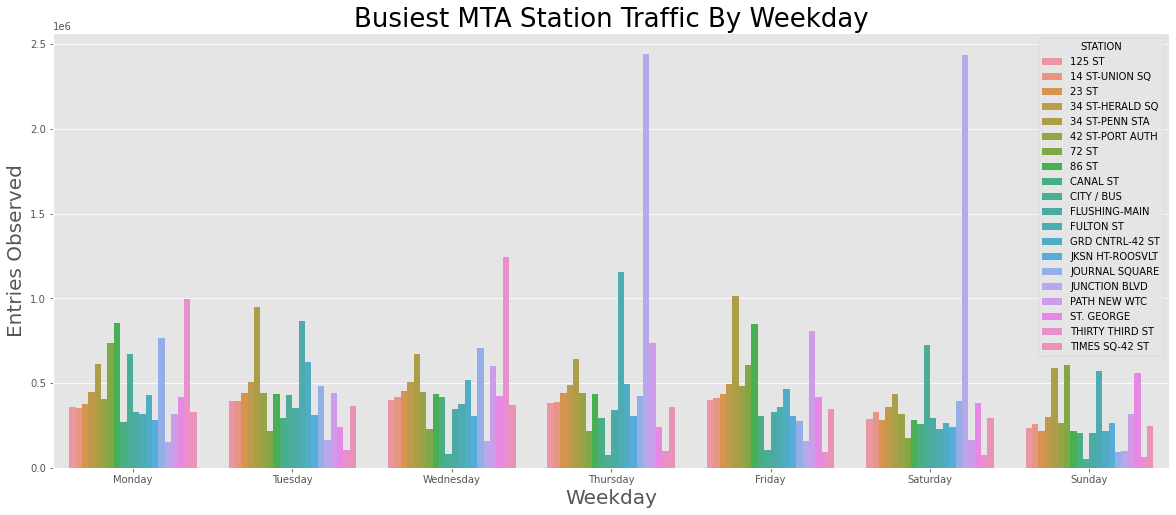

In [48]:
# Create a lineplot of cumulative entries for each station by each weekday
fig=plt.gcf()
fig.set_size_inches(20,8)

ax = sns.barplot(x='WEEKDAY_ORDERED', y='TOTAL_OBSERVED_ENTRIES', hue='STATION', data=filtered_stations_grouped)
ax.set_xlabel(xlabel='Weekday', fontsize = 20)
ax.set_ylabel(ylabel='Entries Observed',fontsize = 20)
ax.set_title(label='Busiest MTA Station Traffic By Weekday', fontsize=26)

#fig.savefig('station_traffic_by_weekday')

In [49]:
# How much funding could be generated by increasing fare rates? The current fare is generally $2.75

fare = 2.75
inc_25c = .25

avg_entries_all_stations = stations_daily.groupby(['STATION'])['DAILY_ENTRIES'].mean()
avg_entries_all_stations = avg_entries_all_stations.to_frame().reset_index()
avg_entries_all_stations.rename(columns={'DAILY_ENTRIES':'AVG_ENTRIES'}, inplace=True)

In [50]:
# Check to see that the math is working correctly

print(avg_entries_all_stations[avg_entries_all_stations['STATION']=='125 ST'])
print(busy_stations_filtered[busy_stations_filtered['STATION']=='125 ST'])

print(avg_entries_all_stations[avg_entries_all_stations['STATION']=='PATH NEW WTC'])
print(busy_stations_filtered[busy_stations_filtered['STATION']=='PATH NEW WTC'])

print(avg_entries_all_stations[avg_entries_all_stations['STATION']=='103 ST-CORONA'])
print(busy_stations_filtered[busy_stations_filtered['STATION']=='103 ST-CORONA'])

#these print-outs are all as expected

  STATION  AVG_ENTRIES
9  125 ST  2234.568574
  STATION  DAILY_ENTRIES  AVG_ENTRIES
0  125 ST      2460260.0  2234.568574
          STATION  AVG_ENTRIES
315  PATH NEW WTC   145.578721
         STATION  DAILY_ENTRIES  AVG_ENTRIES
16  PATH NEW WTC      3379610.0   145.578721
         STATION  AVG_ENTRIES
2  103 ST-CORONA  1682.699634
Empty DataFrame
Columns: [STATION, DAILY_ENTRIES, AVG_ENTRIES]
Index: []


In [51]:
avg_entries_all_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STATION      379 non-null    object 
 1   AVG_ENTRIES  379 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.0+ KB


In [52]:
# Calculate the current average daily revenue for all stations based on a fare of $2.75

avg_entries_all_stations['AVG_REVENUE'] = avg_entries_all_stations['AVG_ENTRIES']*fare

# Calculate the average daily revenue for each station if fares were increased $0.25

avg_entries_all_stations['RATE+.25 REVENUE'] = avg_entries_all_stations['AVG_ENTRIES']*(fare+inc_25c)

# Calculate the average daily revenue for each station if fares were increased 10%

avg_entries_all_stations['RATE+10% REVENUE'] = avg_entries_all_stations['AVG_ENTRIES']*(fare+(fare*0.1))

In [53]:
# Calculate the total revenue right now

baseline_revenue = avg_entries_all_stations['AVG_REVENUE'].sum()
print(f'The total revenue for the observed period is ${round(baseline_revenue)}. Annually, it is approximately ${round(baseline_revenue)*4}.')

The total revenue for the observed period is $806091. Annually, it is approximately $3224364.


In [54]:
# Calculate the projected revenue if fares were increased $0.25

inc_25c_revenue = avg_entries_all_stations['RATE+.25 REVENUE'].sum()

print(f'The projected revenue for the observed period, if fares were increased $0.25, is ${round(inc_25c_revenue)}. Annually, it is approximately ${round(inc_25c_revenue)*4}.')
print(f'The annual funding generated by this increase is approximately ${round((inc_25c_revenue*4)-(baseline_revenue*4))}.')

The projected revenue for the observed period, if fares were increased $0.25, is $879372. Annually, it is approximately $3517488.
The annual funding generated by this increase is approximately $293124.


In [55]:
# Calculate the projected revenue if fares were increased 10%

ten_percent_inc_revenue = avg_entries_all_stations['RATE+10% REVENUE'].sum()

print(f'The projected revenue for the observed period, if fares were increased 10%, is ${round(ten_percent_inc_revenue)}. Annually, it is approximately ${round(ten_percent_inc_revenue)*4}.')
print(f'The annual funding generated by this increase is approximately ${round((ten_percent_inc_revenue*4)-(baseline_revenue*4))}.')

The projected revenue for the observed period, if fares were increased 10%, is $886700. Annually, it is approximately $3546800.
The annual funding generated by this increase is approximately $322436.


In [56]:
# Why have I seen the number 293124 before?

avg_daily_ridership = avg_entries_all_stations['AVG_ENTRIES'].sum()

avg_daily_ridership

293123.97907659516

In [57]:
# Why does the average daily ridership exactly match the annual funds generated from a rate increase of 25 cents??

print(round(avg_daily_ridership) == round((inc_25c_revenue*4)-(baseline_revenue*4)))

True


In [58]:
avg_entries_all_stations.head(10)

,STATION,AVG_ENTRIES,AVG_REVENUE,RATE+.25 REVENUE,RATE+10% REVENUE
0,1 AV,1158.196639,3185.040756,3474.589916,3503.544832
1,103 ST,1755.734545,4828.270000,5267.203636,5311.097000
2,103 ST-CORONA,1682.699634,4627.423993,5048.098901,5090.166392
3,104 ST,1183.075092,3253.456502,3549.225275,3578.802152
4,110 ST,635.374312,1747.279358,1906.122936,1922.007294
5,111 ST,672.048314,1848.132862,2016.144941,2032.946149
6,116 ST,2008.721925,5523.985294,6026.165775,6076.383824
7,116 ST-COLUMBIA,586.955963,1614.128899,1760.867890,1775.541789
8,121 ST,207.237319,569.902627,621.711957,626.892889
9,125 ST,2234.568574,6145.063579,6703.705722,6759.569936
